### Loading the Data and some observations

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -qq /content/drive/MyDrive/Term_4/MLTMBD/cxr_plaksha_assignment_qure.zip

In [4]:
!ls /content/cxr_plaksha_assignment_qure | wc -l

20000


**Some Observations about Data:**

1.Data is unbalanced but skewness is in acceptable limit. There are 26.67% xrays for consolidated tissue.

2.There are some duplicates that have been removed in the init function of cls_dataset class. 



## Implementing a torch dataset and a dataloader(iterator on the dataset).

In [5]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

In [6]:
# A helper function to read png images using cv2.
def read_image_from_path(path):
    try:
        img = cv2.imread(path, 0)
        return cv2.resize(img, (64, 64)) #cv2.imread(path, flag) flag = 0 f0r grayscale
    except Exception as e:
        print(f"error in fpath {path}")

A basic implementation of a torch dataset. 

In [7]:
class cls_dataset(Dataset):
    """A torch classification dataset class which returns each item in the form of dict consisting of keys idx, input, target.
    Transforms are applied on input images.
    """

    def __init__(self, images_path, ground_truth_path):
        self.images_path = images_path
        self.gt_df = pd.read_csv(ground_truth_path, \
                                 usecols=["filename", "consolidation"]).\
                                 drop_duplicates(keep="first").\
                                 set_index("filename")
        self.transforms = ToTensor()

    def __len__(self):
        return len(self.gt_df.index)

    def __getitem__(self, index):

        idx = self.gt_df.index[index]

        input = self._get_input(idx)
        input = self.transforms(input)

        targets = self._get_target(idx)

        return {"idx": idx, "input": input, "target": targets}

    def _get_input(self, idx):
        filepath = os.path.join(self.images_path, str(idx) + ".png")
        return read_image_from_path(filepath)

    def _get_target(self, idx):
        return self.gt_df.loc[idx, "consolidation"]

### Preview the read data

for index 19047 target is 0
for index 17924 target is 0
for index 11658 target is 0
for index 10733 target is 0


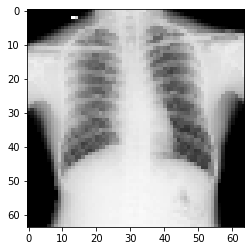

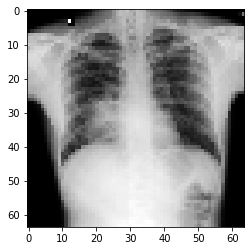

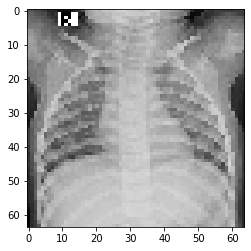

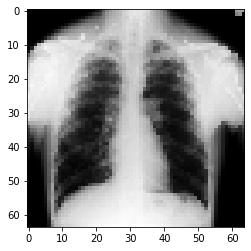

In [9]:
#images_path is where extracted images of xrays are
images_path = "/content/cxr_plaksha_assignment_qure"

#this is where ground truth is stored. 
ground_truth_path = "/content/drive/MyDrive/Term_4/consolidation_train_gt.csv"
train_ds = cls_dataset(images_path, ground_truth_path)

for batch in data.DataLoader(train_ds, batch_size=100):
    # print(batch)
    for i in range(0,4):
        print(f"for index {batch['idx'][i]} target is {batch['target'][i]}")
        image=torch.squeeze(batch['input'][i])
        plt.figure(i)
        plt.imshow(image, cmap='gray')
    break

In [13]:
#Calling the Dataloader API for training Data
trainloader = data.DataLoader(train_ds, batch_size=64,
                                          shuffle=True, num_workers=4)
classes = ('0', '1')

In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2704, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.sigmoid(x)
        return x


net = Net()

In [16]:
import torch.optim as optim

criterion = nn.BCELoss() #BCE Loss since this is a binary claaasificatiob
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [17]:
#We will train for whole of the epochs except for the last one. 
#Last batch of the last epoch is used as test case

prob = []
g_truth = []
epochs = 50
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, d in enumerate(trainloader,0):
        if(i<225 or epoch<(epochs-1)):
            # get the inputs; data is a list of [inputs, labels]
            inputs = d["input"]
            labels = torch.tensor(d["target"])

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            labels = labels.unsqueeze(1).float()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 50 == 49:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.6f}')
                running_loss = 0.0
        else:
            #Testing the Model

            inputs = d["input"]
            labels = d["target"].tolist()
            outputs = net(inputs).tolist()
            prob+=outputs
            g_truth+=labels
            if i % 10 == 9:    # print every 10 mini-batches
                print(f'[Testing, {i + 1:5d}]')

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,    50] loss: 0.307317
[1,   100] loss: 0.288924
[1,   150] loss: 0.296169
[1,   200] loss: 0.291755
[1,   250] loss: 0.285587
[2,    50] loss: 0.288242
[2,   100] loss: 0.280257
[2,   150] loss: 0.280733
[2,   200] loss: 0.274788
[2,   250] loss: 0.274482
[3,    50] loss: 0.270098
[3,   100] loss: 0.271939
[3,   150] loss: 0.272442
[3,   200] loss: 0.271832
[3,   250] loss: 0.273818
[4,    50] loss: 0.281750
[4,   100] loss: 0.270179
[4,   150] loss: 0.272243
[4,   200] loss: 0.260848
[4,   250] loss: 0.268609
[5,    50] loss: 0.273905
[5,   100] loss: 0.272616
[5,   150] loss: 0.266493
[5,   200] loss: 0.268247
[5,   250] loss: 0.261336
[6,    50] loss: 0.263256
[6,   100] loss: 0.262200
[6,   150] loss: 0.267257
[6,   200] loss: 0.272324
[6,   250] loss: 0.266967
[7,    50] loss: 0.268054
[7,   100] loss: 0.261865
[7,   150] loss: 0.263273
[7,   200] loss: 0.264844
[7,   250] loss: 0.263207
[8,    50] loss: 0.263414
[8,   100] loss: 0.263436
[8,   150] loss: 0.257519
[8,   200] l

# Validating Model and getting AUC

In [18]:
from sklearn import metrics
import matplotlib.pyplot as plt

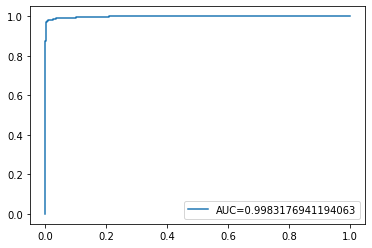

In [19]:
#Checking the AUC Score of the predictor!

fpr, tpr, _ = metrics.roc_curve(g_truth,  prob)
auc = metrics.roc_auc_score(g_truth, prob)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()


# Predicitng for the withheld data(4000 examples)

In [22]:
#images_path = "cxr_plaksha_assignment_qure"
train_filename = pd.read_csv("/content/drive/MyDrive/Term_4/consolidation_train_gt.csv").filename
#getting series of filenames alreaady covered in training

In [23]:
#reading all the files from the image repositiory and predicting 
#for those that were not present in the train data
img_id = []#ID of untouched image
test_pred = []
for f in os.listdir(images_path):
  filename = os.path.splitext(f)[0]
  if(sum(train_filename.isin([int(filename)]))==0):
    img = read_image_from_path(images_path+"/"+str(f))
    img = ToTensor()(img)
    img_id.append(filename)
    test_pred+=net(img.reshape(1,1,64,64)).tolist()[0]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [24]:
df_test_pred = pd.DataFrame(zip(img_id, test_pred), columns = ["filename", "confidence_score"])

In [25]:
df_test_pred.set_index("filename", inplace = True)
df_test_pred.head()

,confidence_score
filename,
277,7.962353e-01
13764,9.128760e-07
12246,4.362410e-04
10998,1.744897e-12
14677,1.526777e-07


In [31]:
df_test_pred.to_csv("/content/drive/MyDrive/Term_4/MLTMBD/xray_pred_0.99AUC.csv")

In [32]:
PATH = '/content/drive/MyDrive/Term_4/model_accurate_0.99.pth'
torch.save(net.state_dict(), PATH)